# Risk Premium: Choosing Adequate Discount Rates For Crypto Assets

*** Updated the previous version, mostly to fix the issue where CAPM like models counter-intuitively decrease the required rate of return for high beta assets in increasing interest rate environment.


## 1. Problem definition

"If it is difficult to estimate a reliable historical premium for the US market, it becomes doubly so, when looking at markets with short, volatile and transitional histories. This is clearly true for emerging markets, where equity markets have often been in existence for only short time periods (Eastern Europe, China) or have seen substantial changes over the last few years (Latin America, India)." How about crypto? :)

## 2. Existing approaches in crypto industry

Lack of standardized framework. It appears that there is a certain consensus in the industry of using arbitrary selected 40% discount rate when evaluating crypto assets. 

## 3. TradFi approaches: CAPM Model or WACC model

WACC model is obviously not possible to implement for majority of crypto assets. CAPM model with S&P 500 as a proxy for the market risk premium, also doesn't make much sense as in practice crypto idiosyncratic risk is quite high, beta is often negative and fluctuates significantly from one period to another. 

Below we will show Bitcoin Beta vs S&P 500.



## 4. Proposing a framework for crypto assets - Relative standard deviation

"There are some analysts who believe that the equity risk premiums of markets
should reflect the differences in equity risk, as measured by the volatilities of these markets.
A conventional measure of equity risk is the standard deviation in stock prices; higher
standard deviations are generally associated with more risk. If you scale the standard deviation of one market against another, you obtain a measure of relative risk."

Assuming linear relationship between risk premium and standard deviation we calculate risk premium for asset x as: 

### risk_premium(x) = risk_premium(s&p) * stdev(x)/stdev(s&p)

Hence, required rate of return from a particular asset is represented as:

### Required_R(x) = rf_rate + risk_premium(x) 

or in full form:

### Required_R(x) = rf_rate + risk_premium(s&p) * stdev(x)/sdev(s&p)

### Obstacles with the model 
- survivor bias in S&P 500 overestimating risk premium 
- two assets may have same standard deviation but different skew and kurtosis 
- Since equity market volatility is affected by liquidity, with more liquid markets often showing higher
volatility, this approach will understate premiums for illiquid markets and overstate the
premiums for liquid markets. Thus, it may be wise to use the model for crypto assets that are considered relatively mature and liquid.

### Ideas for further improving calculations
-  To avoid this bias add another standardized parameter to reflect market liquidity e.g. market_cap / trading volume of asset x vs average market_cap / trading volume for the top 100 crypto assets.
- Make formula sensitive to skew and kurtosis 

## 5. Building the intuition; Other factors that need to be considered 
### Factors lowering risk premium:
- less professional investment audience, larger participation from retail -> lower risk premium 
- younger audience -> lower risk premium [Bakshi, G. S., and Z. Chen, 1994, Baby Boom, Population Aging, and Capital Markets, The Journal of Business, LXVII, 165-202.]
- low savings rate -> lower risk premiums [https://deliverypdf.ssrn.com/delivery.php?ID=739098086122105025069117000097119011123049028029039027085071072111098107126096118094055034030123018059015112065096071097086115038013054059039029117110064089029059022000119091119095024096101027015092026092102103086098125086003110028103024110095002&EXT=pdf&INDEX=TRUE]
- predictability - e.g. BTC monetary policy will be the same 20 years from now (ETH not on the other hand may not)

### Factors increasing risk premium:
- larger uncertainty (geopolitical, regulatory, etc.) | fat tails, low kurtosis
- lower quality of information, information overload, less trust in protocols e.g. rug pulls, insider trading, etc.
- higher volatility of earning (e.g. volatile trading volume for DEXs) 
- illiquidity of the token
- "Myopic loss aversion refers to the finding in behavioral finance that the loss aversion already embedded in individuals becomes more pronounced as the frequency of their monitoring increases. Thus, investors who receive constant updates on equity values actually perceive more risk in equities, leading to higher risk premiums." As passive investing is still not a thing in crypto (e.g. less index funds, ETFs) the risk premiums are higher. However, if we assume more people holding long term regardless of the price and more passive funds entering the market in the future, risk premiums should decrease. 
- Negative skew
- Significant unlock of the new tokens to the market

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
import matplotlib as mpl
import quandl
from pandas_datareader.yahoo.daily import YahooDailyReader 
import CoinGeckoFunctions as cgf
from sklearn.linear_model import LinearRegression
import yfinance as yf
import tokenterminal as tt
import requests
import json

pd.set_option('display.float_format', lambda x: '%.4f' % x) ## change float at the macro level
plt.rcParams["figure.figsize"] = (14, 6) ## change plot size at the macro level
mpl.rcParams['figure.dpi'] = 300 ## graph resolution

In [136]:
start = dt.datetime(2013,1,1)
end = dt.datetime.today()

def get_price(token, start=str(start)[:10], end=str(end)[:10]):

    url = "https://api.tokenterminal.com/v2/projects/" + token + "/metrics?metric_ids=price&start=" + start + "&end=" + end + "&order_direction=desc"
    response = requests.get(url, headers=headers)
    headers = {"Authorization": "KEY"}

    data_shows = json.loads(response.text)
    data = data_shows['data']

    date = []
    price = []

    for i in range(len(data)):
        date.append(dt.datetime(int((data[i]['timestamp'])[:4]), int((data[i]['timestamp'])[5:7]), int((data[i]['timestamp'])[8:10])))
        price.append(data[i]['price'])

    return pd.DataFrame(data = price, index = date, columns = [token]).iloc[::-1].dropna()

In [138]:
market_RP = 0.055

### Importing S&P and crypto price data

In [140]:
start = dt.datetime (2015, 1, 1)
end = dt.datetime.today()  

## S&P500

In [141]:
snp = yf.Ticker("^GSPC")
df = snp.history(period="60y")
df = df["Close"]

date = []
for i in range(len(df.index)):
    date.append(dt.datetime(df.index[i].year, df.index[i].month, df.index[i].day))
    
df.index=date
df.index = pd.to_datetime(df.index)
df = pd.DataFrame(df)

In [142]:
coin = get_price('bitcoin')

In [143]:
index = []
for i in range(len(coin)): 
    index.append(dt.datetime(coin.index[i].year, coin.index[i].month, coin.index[i].day))
    
coin.index = index

### Cleaning data, making sure dates are matching

In [144]:
coin = coin.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
coin = coin.loc[coin.index.isin(list(df.index))]
df = df.loc[df.index.isin(list(coin.index))]

### Lognormal Returns

In [145]:
def log_rates (data):
    
    return (np.log(data)-np.log(data.shift(1)))[1:]

In [146]:
df_CCR = (np.log(df)-np.log(df.shift(1)))[1:]
coin_CCR = (np.log(coin)-np.log(coin.shift(1)))[1:]

### Time Intervals For Calculating Parameters 
- default at 30 i.e. monthly data

In [147]:
def intervals(interval = 30, start = dt.datetime(2020,1,1), end = dt.datetime.today()):
    
    '''''''''
    interval - default set at 30 implying monthly data.
    '''''''''
    
    num_periods = int((end - start).days / interval)
    
    start = pd.to_datetime(end.date())
    starts = [start]
    for i in range(num_periods):
        starts.append(starts[i] - dt.timedelta(interval))
    
    starts.reverse()
    
    return starts

In [148]:
dates = intervals(30)

## Beta and Correlation Calculation

In [149]:
def calculate_beta(market, crypto, start, end):
    
    x = market[(market.index>=start) * (market.index<end)]
    y = crypto[(crypto.index>=start) * (crypto.index<end)]
    
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y.values)
    
    return model.coef_[0][0]

def beta_TS(market, crypto, dates):
    
    coef = []
    ends = []

    for i in range(len(dates)-1):

        coef.append(calculate_beta(market, crypto, dates[i], dates[i+1]))
        ends.append(dates[i+1])    
        
    return pd.DataFrame(data=coef, index = ends, columns = ['Beta'])

In [150]:
def calculate_corr(market, crypto, start, end):

    x = market[(market.index>=start) * (market.index<end)]
    y = crypto[(crypto.index>=start) * (crypto.index<end)]
    
    return pd.concat([x, y], axis = 1).corr().iloc[0, 1]

def corr_TS (market, crypto, dates):
    
    corr = []
    ends = []

    for i in range(len(dates)-1):

        corr.append(calculate_corr(market, crypto, dates[i], dates[i+1]))
        ends.append(dates[i+1])

    return pd.DataFrame(data=corr, index = ends, columns = ['Correlation'])

In [151]:
def calculate_std(returns, start, end):

    returns = returns[(returns.index>=start) * (returns.index<end)]
    
    return np.std(returns)[0]

def std_TS (returns, dates):
    
    std = []
    ends = []

    for i in range(len(dates)-1):

        std.append(calculate_std(returns, dates[i], dates[i+1]))
        ends.append(dates[i+1])

    return pd.DataFrame(data=std, index = ends, columns = ['Standard Deviation'])

In [152]:
calculate_beta(df_CCR, coin_CCR, dates[0], dates[-1])

0.467649840189952

In [153]:
beta = beta_TS(df_CCR, coin_CCR, dates)
corr = corr_TS(df_CCR, coin_CCR, dates)


print ("Table illustrates correlation between S&P 500 and crypto returns, as well as crypto Beta relative to S&P 500")
pd.concat([corr, beta], axis = 1)

Table illustrates correlation between S&P 500 and crypto returns, as well as crypto Beta relative to S&P 500


,Correlation,Beta
2020-02-14,0.0281,0.0662
2020-03-15,-0.0192,-0.0302
2020-04-14,0.3703,0.3715
2020-05-14,0.3285,0.7048
2020-06-13,0.2315,0.3096
2020-07-13,0.3262,0.3396
2020-08-12,0.1299,0.3993
2020-09-11,0.3515,0.5621
2020-10-11,0.4893,0.6029
2020-11-10,0.2010,0.3045


## Rolling Average

In [154]:
def corr_rolling(period, data1, data2):
    
    '''''''''
    period - number of days
    '''''''''
    
    corr = []
    date = []

    for i in range(period, len(data1)):
        x = data1[i-period:i]
        y = data2[i-period:i]

        date.append(data1.index[i])    
        corr.append(pd.concat([x,y], axis=1).corr().iloc[0,1])

    return pd.DataFrame(data=corr, index=date, columns=['corr'])   

In [155]:
def beta_rolling(period, data1, data2):
    
    beta = []
    date = []

    for i in range(period, len(data1)):
        x = data1[i-period:i]
        y = data2[i-period:i]
        
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        
        date.append(data1.index[i])    
        beta.append(model.coef_[0][0])
    
    return pd.DataFrame(data=beta, index=date, columns=['beta'])   

In [156]:
corr10 = corr_rolling(10, df_CCR, coin_CCR)
corr30 = corr_rolling(30, df_CCR, coin_CCR)
corr90 = corr_rolling(90, df_CCR, coin_CCR)

In [157]:
beta10 = beta_rolling(10, df_CCR, coin_CCR)
beta30 = beta_rolling(30, df_CCR, coin_CCR)
beta90 = beta_rolling(90, df_CCR, coin_CCR)

In [158]:
def standardize (data, base = 1000):
    
    '''''''''
    data - pd.Series
    '''''''''
    
    data[0] = base
    
    for i in range(len(data)-1):
        data[i+1] = np.exp(data[i+1] + np.log(data[i]))
    
    return data

In [159]:
coin1000 = standardize(coin_CCR.copy()[coin_CCR.index.year>=2022]['bitcoin'])
sp1000 = standardize(df_CCR.copy()[df_CCR.index.year>=2022]['Close'])
stand = pd.concat([sp1000, coin1000], axis=1)

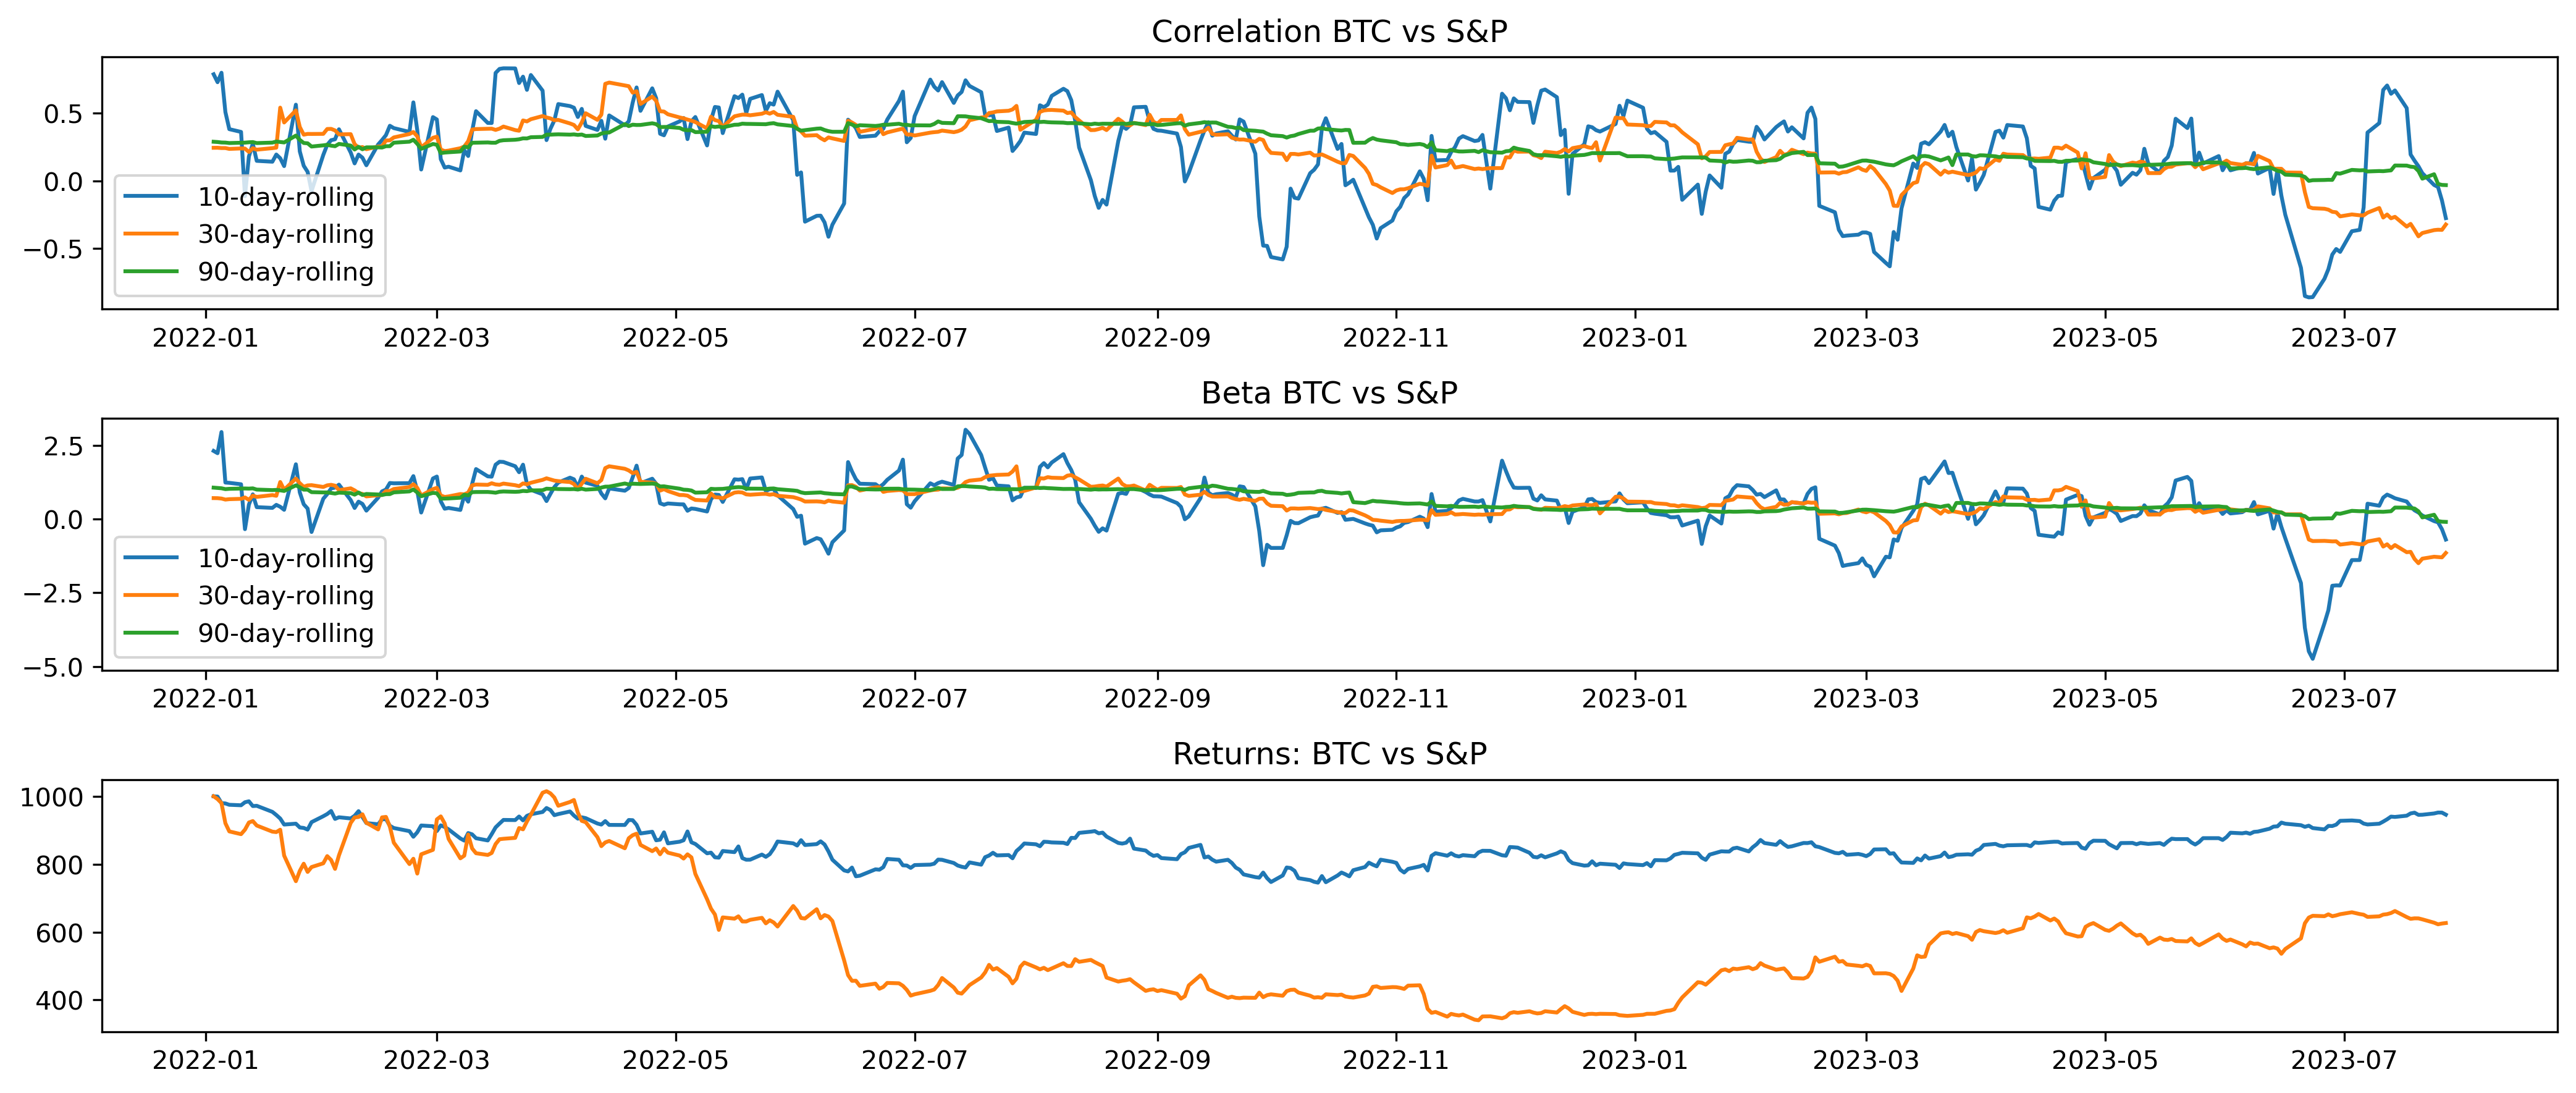

In [160]:
fig, ax = plt.subplots(3, 1)

ax[0].plot(corr10[corr10.index.year>=2022], label = '10-day-rolling')
ax[0].plot(corr30[corr30.index.year>=2022], label = '30-day-rolling')
ax[0].plot(corr90[corr90.index.year>=2022], label = '90-day-rolling')
ax[0].legend()
ax[0].set_title('Correlation BTC vs S&P')

ax[1].plot(beta10[beta10.index.year>=2022], label = '10-day-rolling')
ax[1].plot(beta30[beta30.index.year>=2022], label = '30-day-rolling')
ax[1].plot(beta90[beta90.index.year>=2022], label = '90-day-rolling')
ax[1].legend()
ax[1].set_title('Beta BTC vs S&P')

ax[2].plot(stand, label = 'BTC vs S&P')
ax[2].set_title('Returns: BTC vs S&P')

plt.tight_layout()
plt.show()

# Summary statistics 

In [161]:
snp = snp.history(period="60y")
snp = snp["Close"]


date = []
for i in range(len(snp.index)):
    date.append(dt.datetime(snp.index[i].year, snp.index[i].month, snp.index[i].day))
    
snp.index=date
snp.index = pd.to_datetime(snp.index)
snp = pd.DataFrame(snp)

In [162]:
def summary_stats(returns1, returns2, column1, column2):

    full = pd.concat([returns1.describe(), returns2.describe()], axis=1)
    full.columns = [column1, column2]
    
    full = full.append(pd.DataFrame(data=([returns1.skew()[0], returns2.skew()[0]], 
                  [returns1.kurtosis()[0], returns2.kurtosis()[0]]), index = ['Skew', 'Kurtosis'],
            columns=[column1, column2]))
    
    full[column1 + '/' + column2] = full[column2]/full[column1]
    return full

In [163]:
summary_stats(pd.DataFrame(log_rates(snp)), pd.DataFrame(coin_CCR), 'S&P', 'BTC')

C:\Users\amidz\AppData\Local\Temp\ipykernel_10812\159248706.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full = full.append(pd.DataFrame(data=([returns1.skew()[0], returns2.skew()[0]],


,S&P,BTC,S&P/BTC
count,15101.0000,2577.0000,0.1707
mean,0.0003,0.0021,7.4551
std,0.0105,0.0451,4.3055
min,-0.2290,-0.2518,1.0995
25%,-0.0044,-0.0158,3.6311
50%,0.0005,0.0021,4.5930
75%,0.0052,0.0202,3.8739
max,0.1096,0.3144,2.8695
Skew,-0.9892,0.0418,-0.0422
Kurtosis,25.0760,6.0647,0.2419


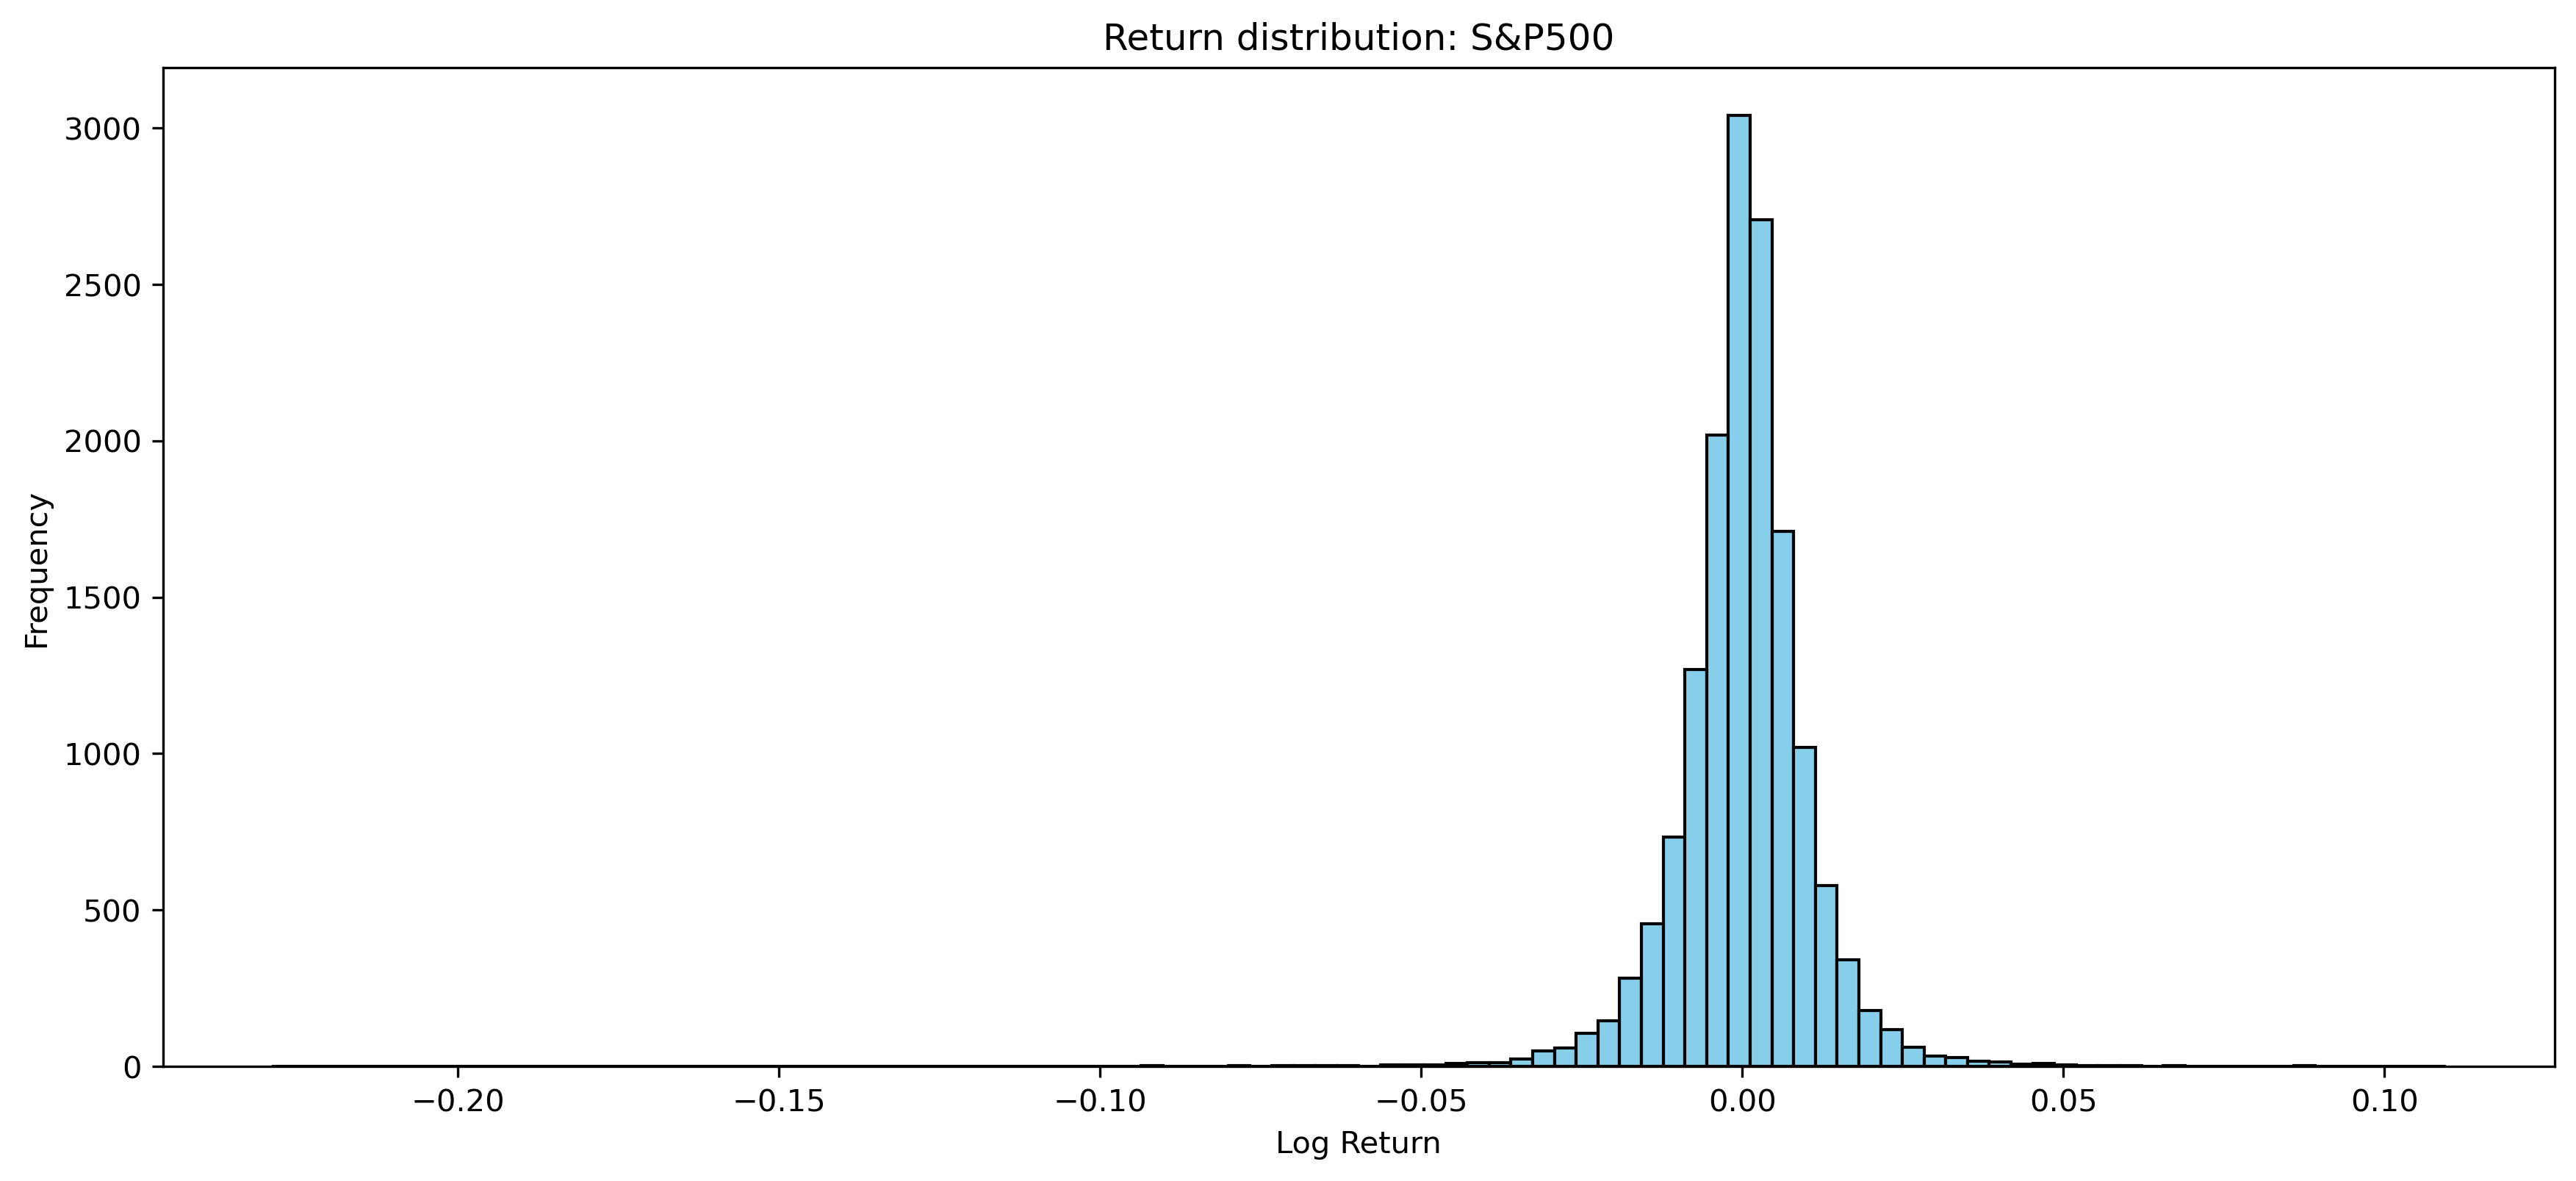

In [164]:
plt.hist(log_rates(snp), bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.title('Return distribution: S&P500')
plt.show()

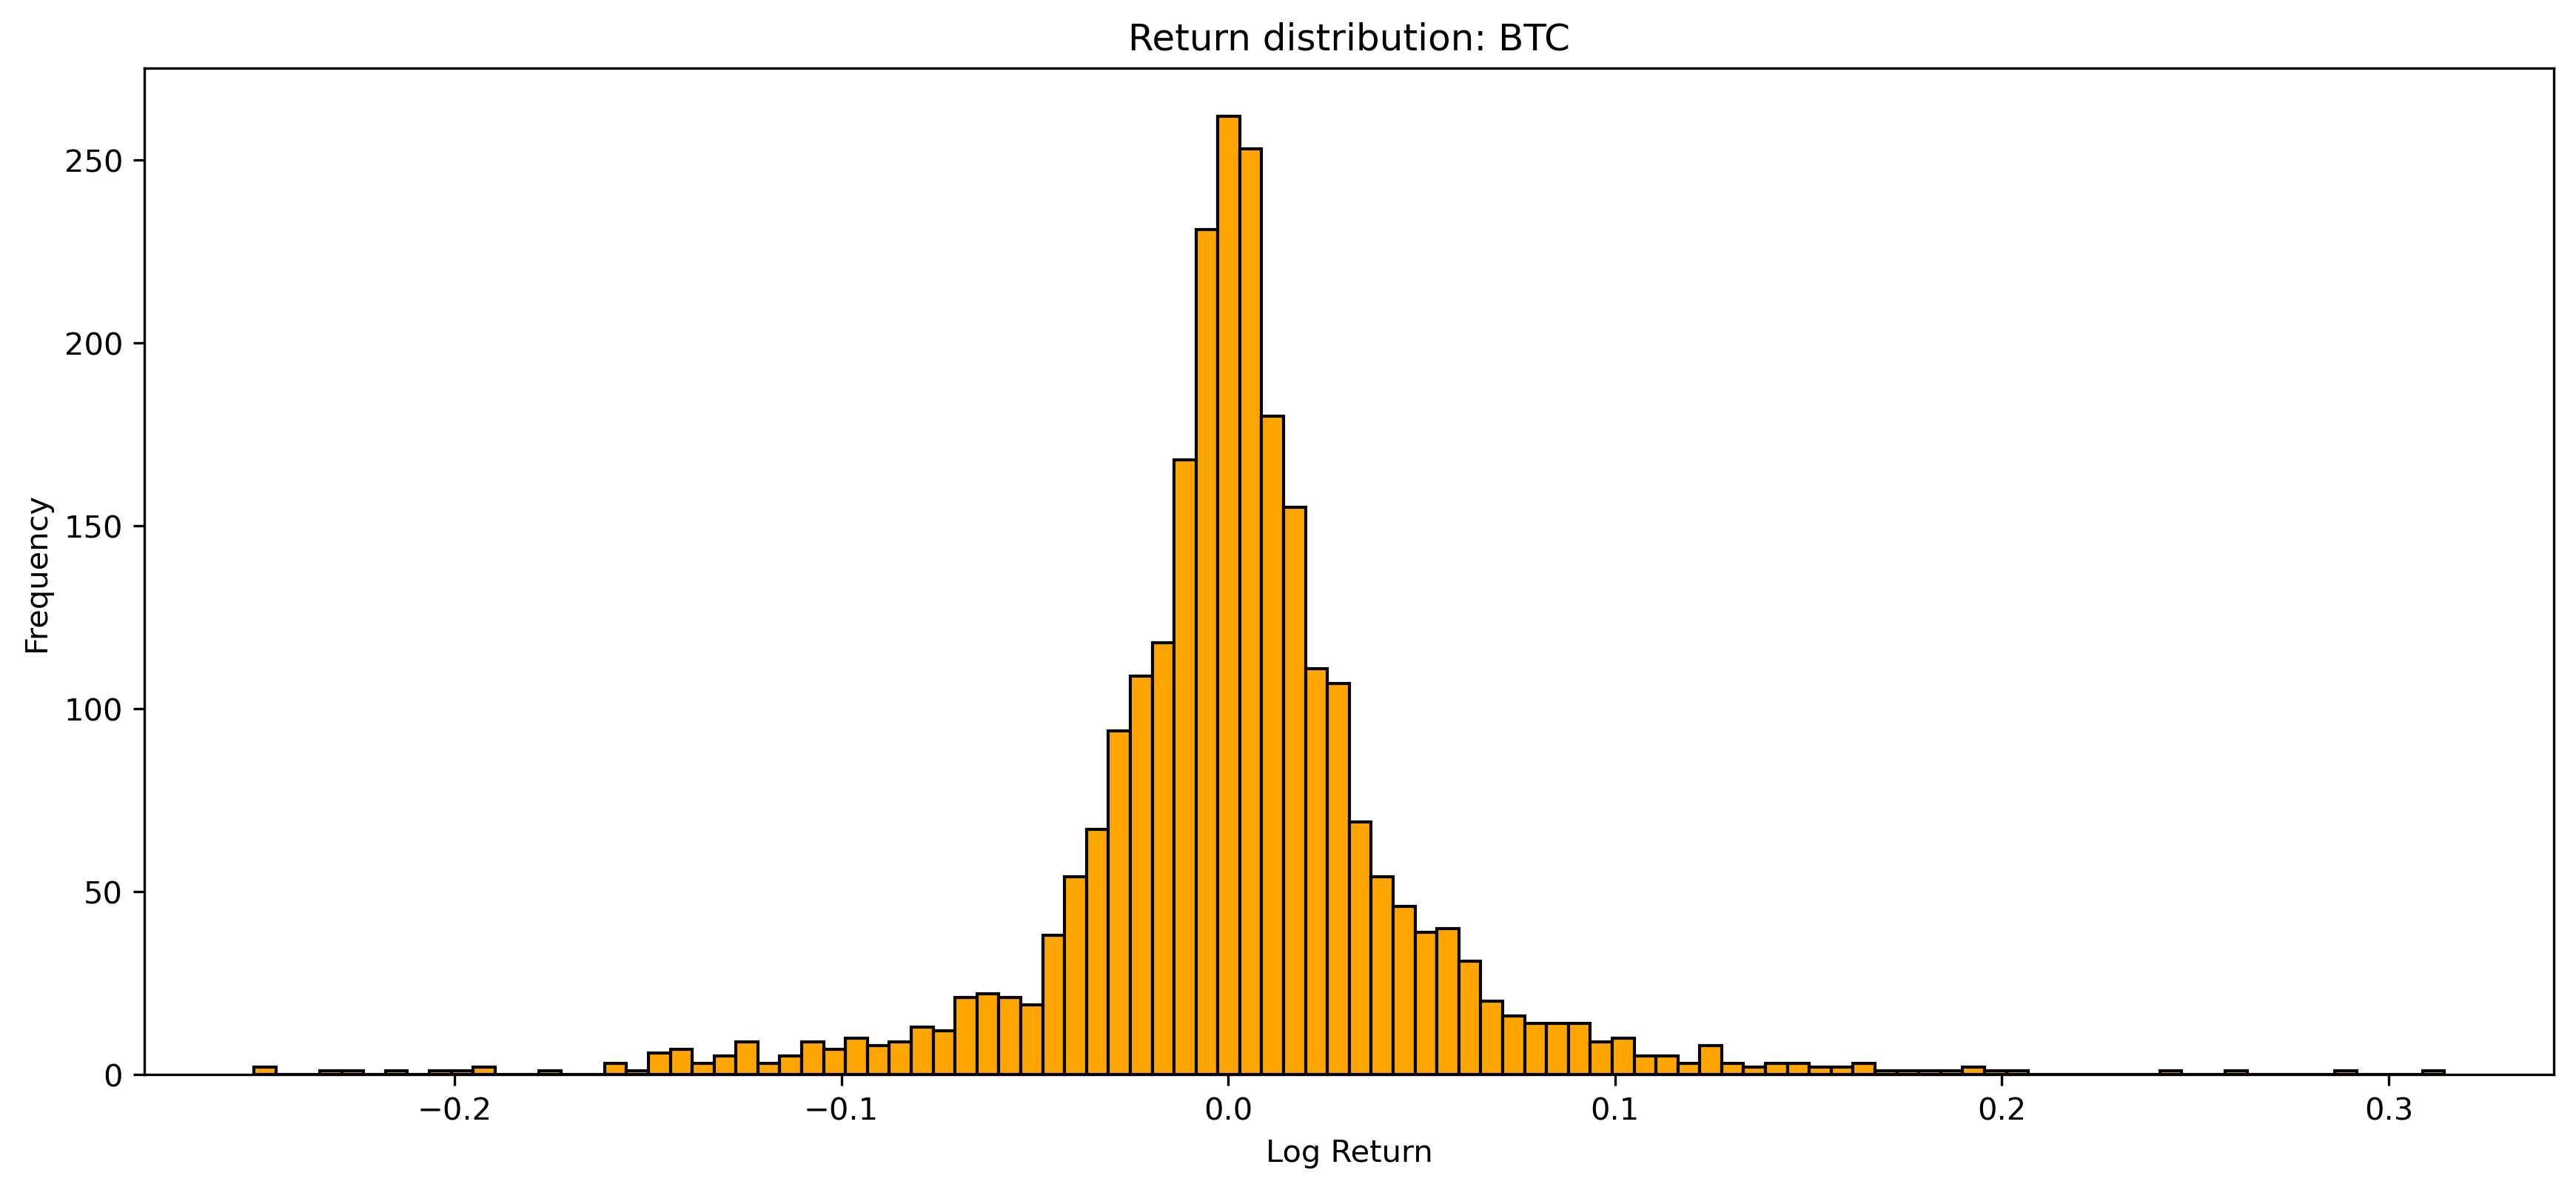

In [165]:
plt.hist(coin_CCR, bins=100, color='orange', edgecolor='black')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.title('Return distribution: BTC')
plt.show()

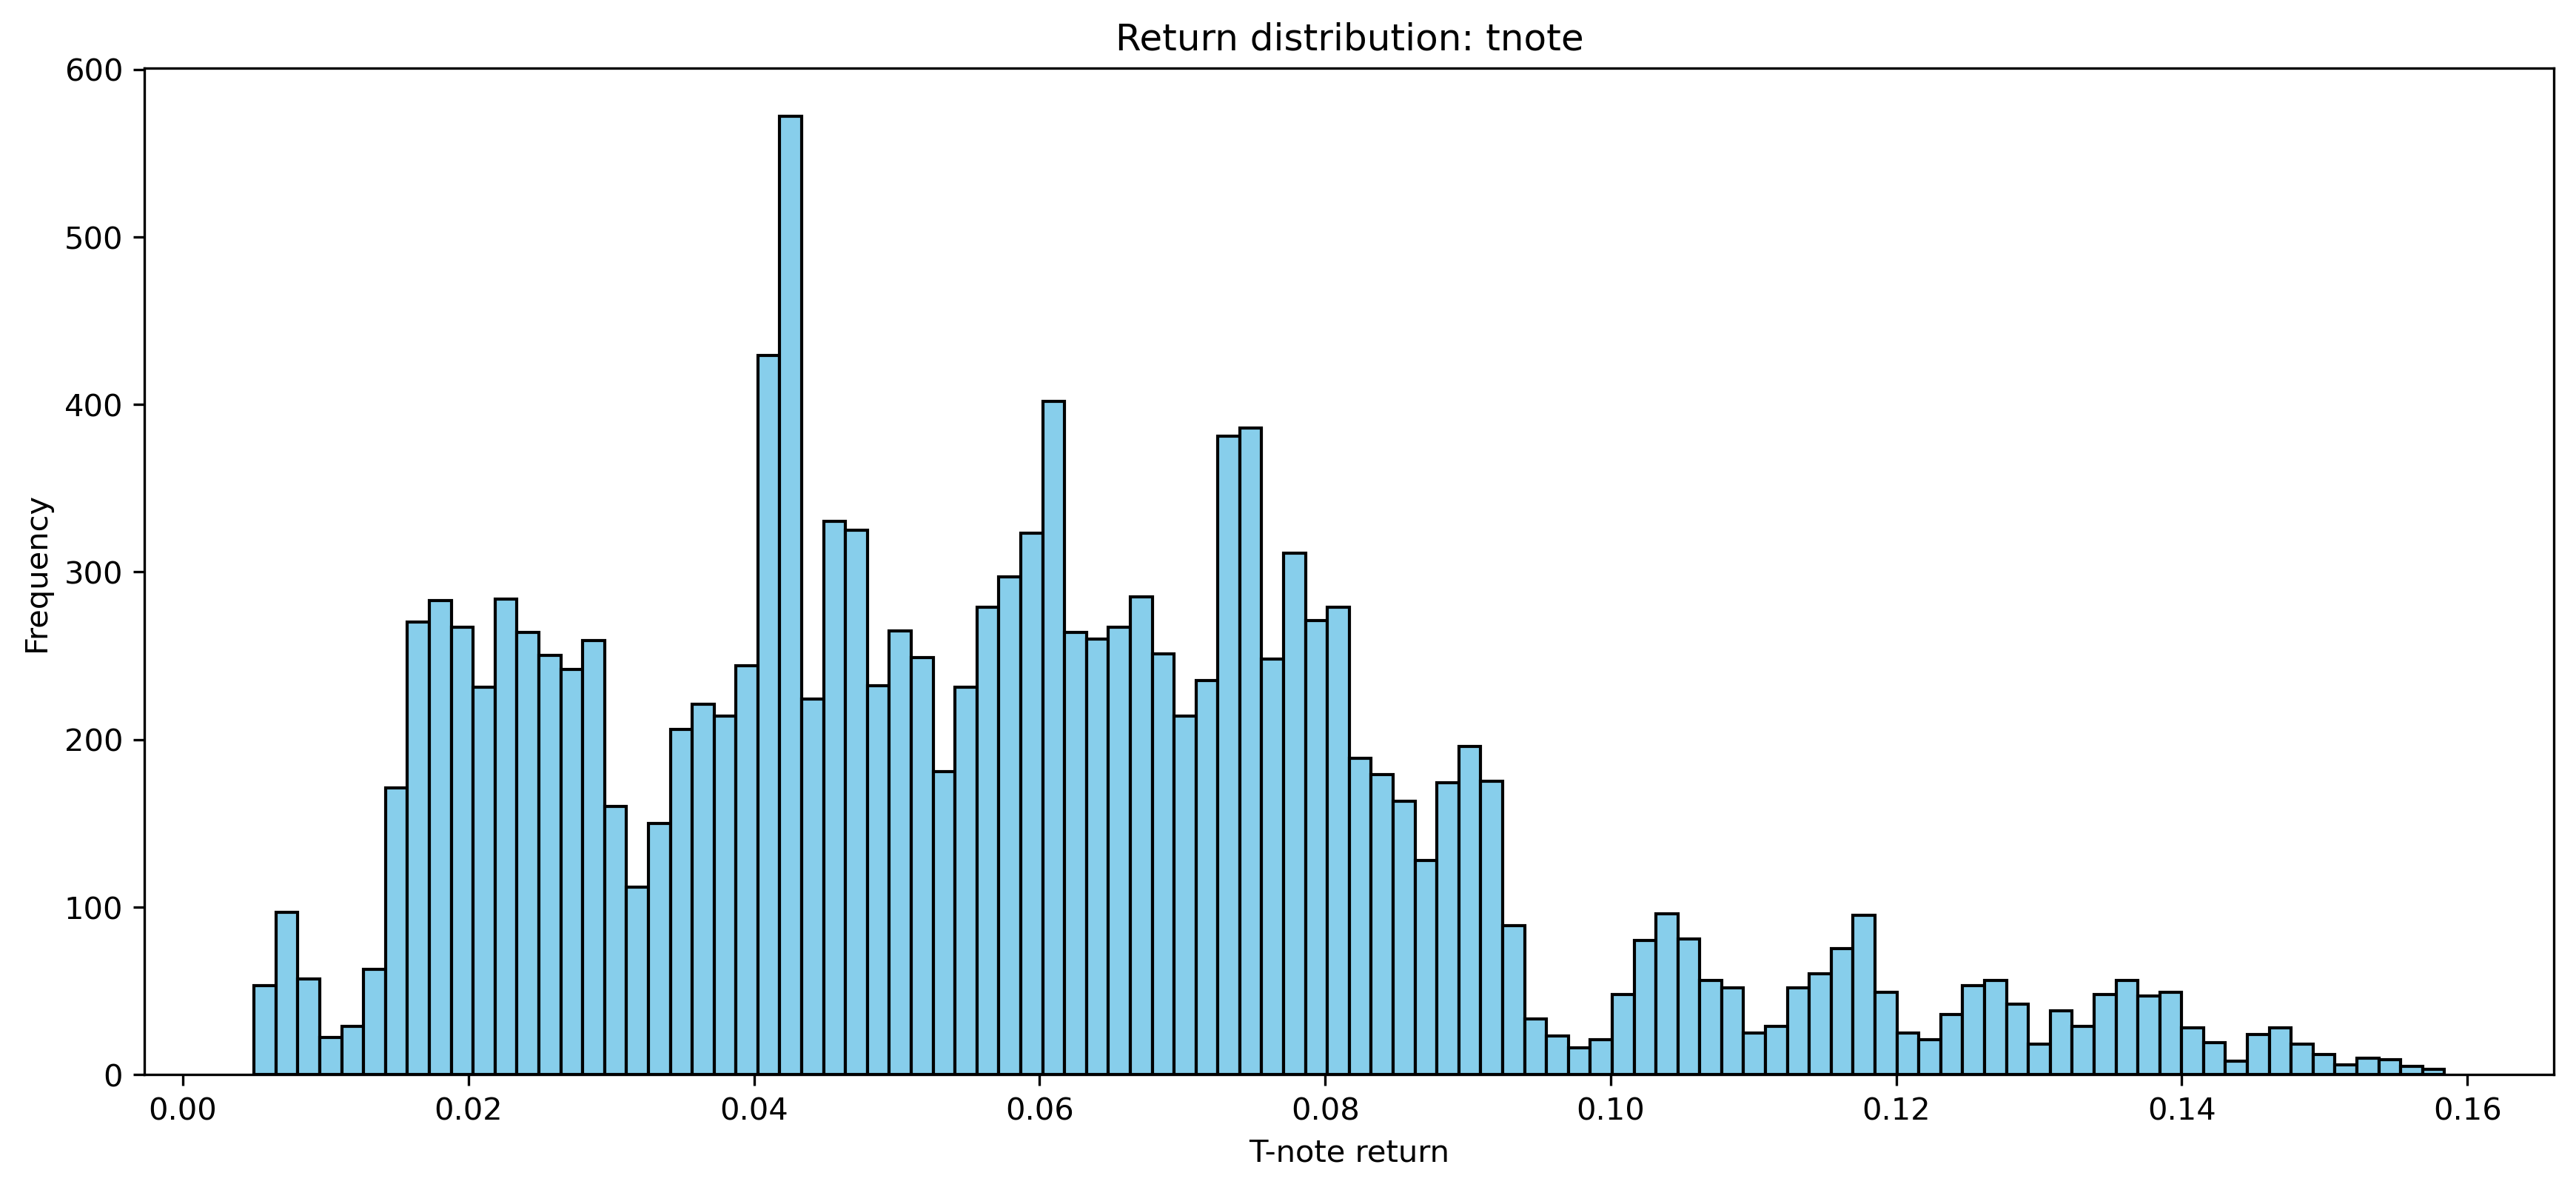

In [166]:
tn = yf.Ticker("^TNX")
tnote = tn.history(period="60y")
tnote = tnote['Close']

plt.hist(tnote/100, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('T-note return')
plt.ylabel('Frequency')
plt.title('Return distribution: tnote')
plt.show()

# Calculate market risk premium using full historical data 
- define as long term market risk premium 

### Long Term Annualized Rate of Return on S&P500

In [167]:
(1+log_rates(snp).mean())**253-1

Close   0.0727
dtype: float64

### Average Bond Price

In [168]:
tnote.mean()

5.921532304575848

In [169]:
bond_price = 100/(1+tnote/100)**10

<AxesSubplot:xlabel='Date'>

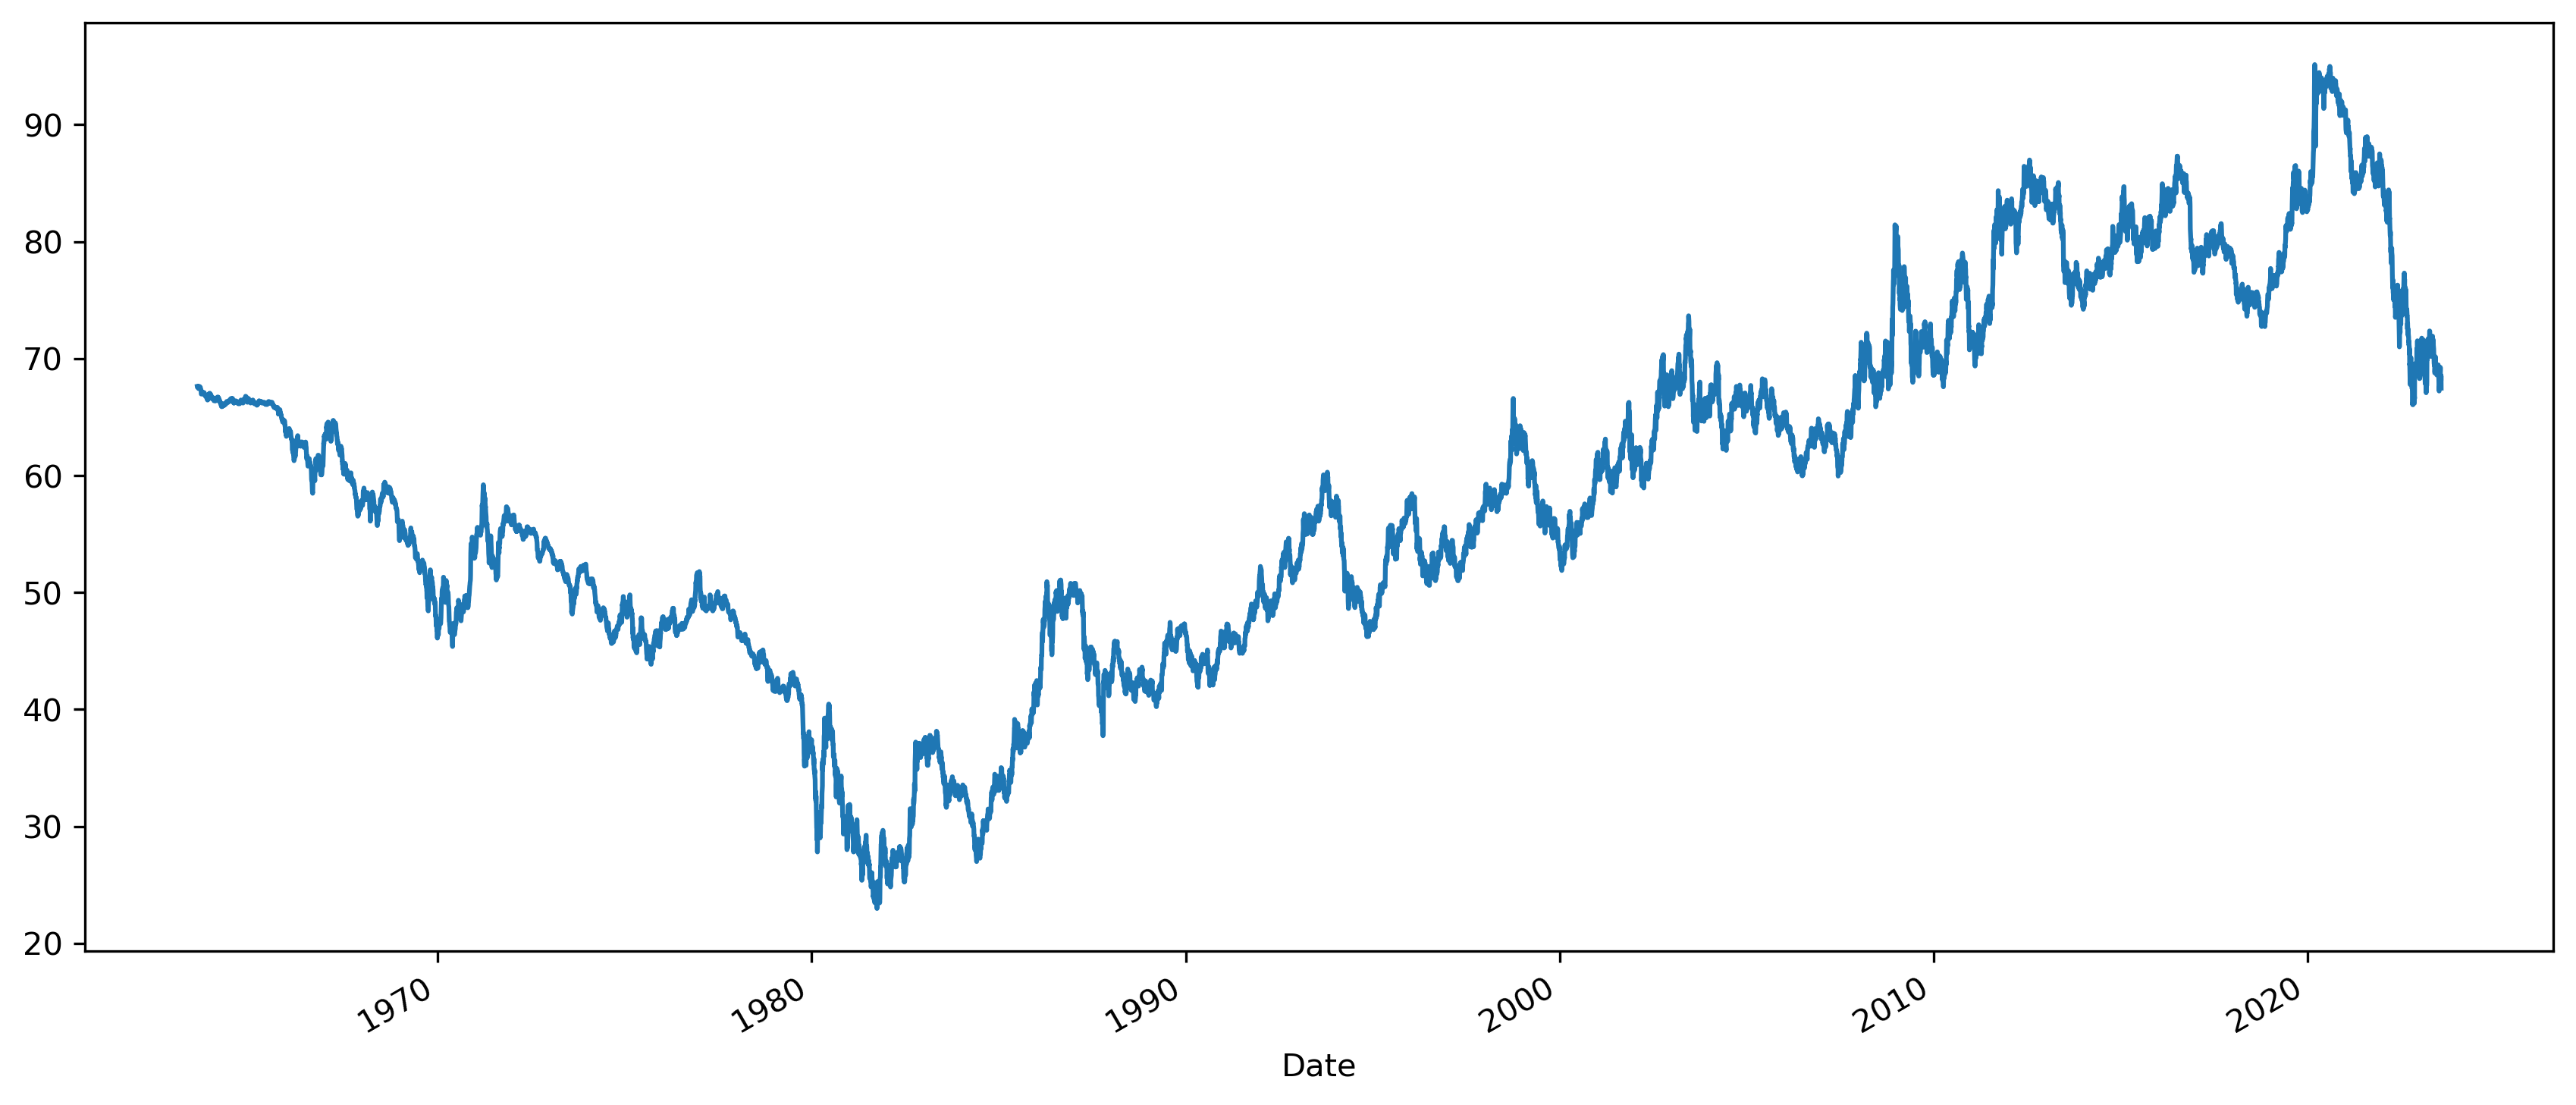

In [170]:
bond_price.plot()

### Bond prices

In [171]:
range_ = np.arange(0, len(bond_price), round(len(bond_price)/6) - 1)

bond_t0 = []

for i in range_:
    bond_t0.append(bond_price[i])

bond_t0

[67.62140927977622,
 48.1597921182569,
 33.45998031255324,
 58.877047741294106,
 64.22663102983216,
 77.45985992426016,
 68.51216839743036]

### Invest & hold at start of each period

In [172]:
bond_returns = []

for i in range(len(bond_t0)):
    bond_returns.append((100/bond_t0[i])**(1/10)-1)
    
bond_returns

[0.03990000009536754,
 0.0757999992370606,
 0.11569999694824218,
 0.05440000057220451,
 0.045269999504089276,
 0.025869998931884686,
 0.03854000091552745]

In [173]:
return_10_years = (1 + np.array(bond_returns))**10

return_10_years

array([1.47882159, 2.07642092, 2.98864491, 1.69845473, 1.55698654,
       1.29099123, 1.45959473])

### Geometric annual return

In [174]:
((np.cumprod(return_10_years)**(1/60))[-1]-1)

0.06578596904826894

### Realized premium (past 60 years)

In [175]:
((1+log_rates(snp).mean())**253-1) - ((np.cumprod(return_10_years)**(1/60))[-1]-1)

Close   0.0069
dtype: float64

# Survey Data

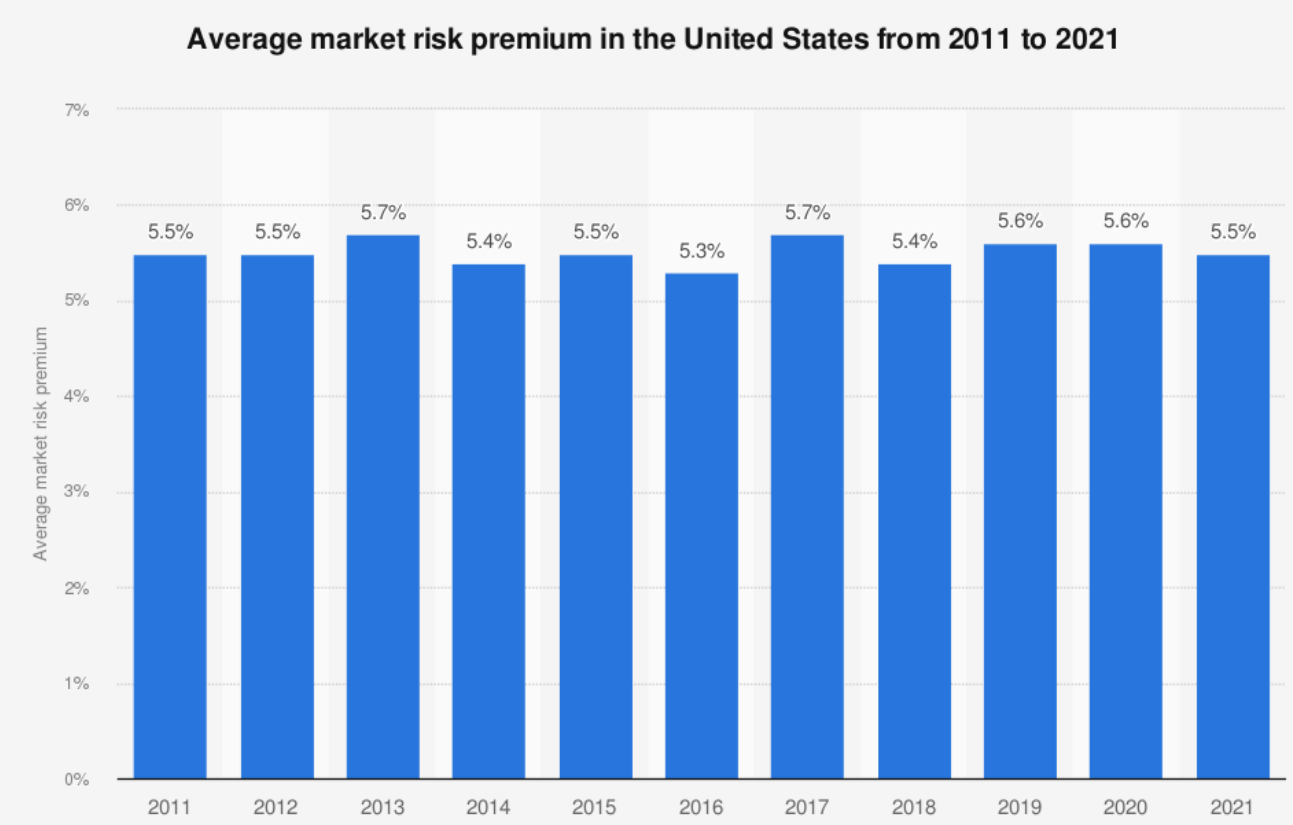

# Conclusion 
- For simplicity take market risk premium to be around 4%

# If we use 50 years of stock data does it implies we should use as long as possible time period for crypto assets? 
- Not necessarily. The above discussion suggest that with crypto which is a new asset class we may have to re-consider the length of time used for estimating any of the inputs. Bitcoin only has 10+ years of the price history data over which the public perception of Bitcoin has change significantly. In the first few years it may have been an asset that was attracting only geeks, growing into highly speculative asset to an asset that is being purchased by publicly listed US companies. 
- Prudent approach would be to observe how significantly distribution of returns, standard deviation and other important metrics of an assets have changed with time and hence choose how long time periods we want. 
- Coingecko offers BTC data only from 2013 onwards. The key metric we are focused is the relative standard deviation. Regardless of the period we choose, relative standard deviation is almost constantly in the range 3.5 - 3.8. Therefore, for simplicity we would just use full historical data for any crypto asset. 

In [176]:
btc = get_price('bitcoin')
btc_CCR = log_rates(btc)

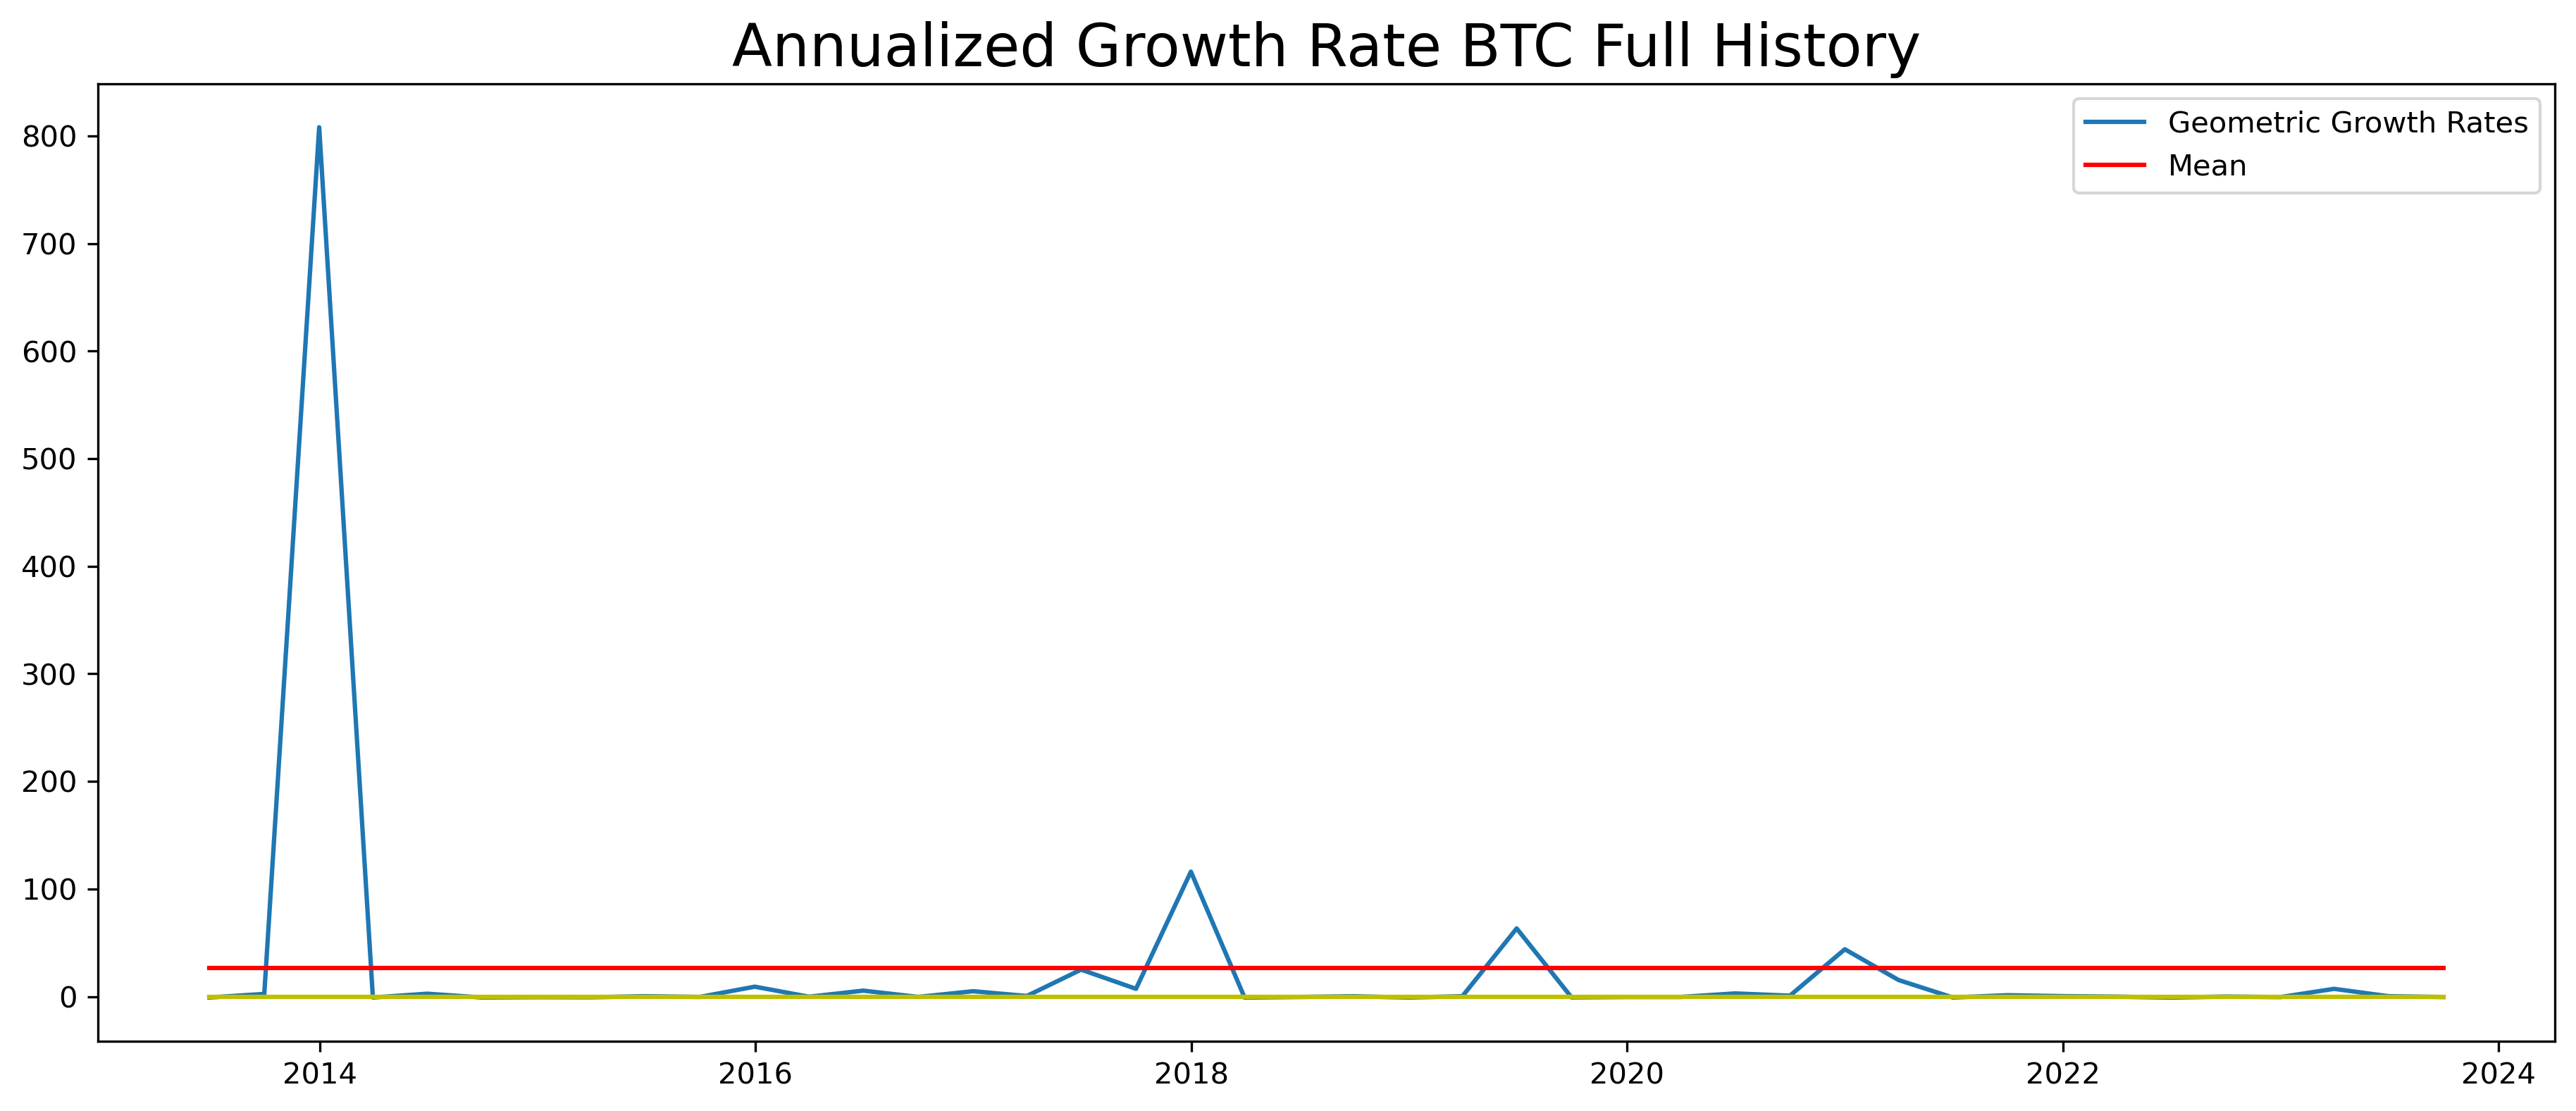

In [177]:
bggr = ((1 + btc_CCR.groupby(pd.Grouper(freq='Q')).mean())**356 - 1)
zeros = pd.Series(data = np.zeros(len(bggr)), index=bggr.index)
mean = pd.Series(data = np.ones(len(bggr)) * bggr.mean()[0], index=bggr.index)

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(bggr, label = 'Geometric Growth Rates')
ax.plot (zeros, 'y')
ax.plot (mean, 'r', label = 'Mean')
ax.legend()
plt.title('Annualized Growth Rate BTC Full History', fontsize = 20)
plt.show()

In [178]:
dates = intervals(30, start = btc_CCR.index[0])

## Standard Deviation Time Series

<AxesSubplot:title={'center':'Annualized Monthly BTC Stdev'}>

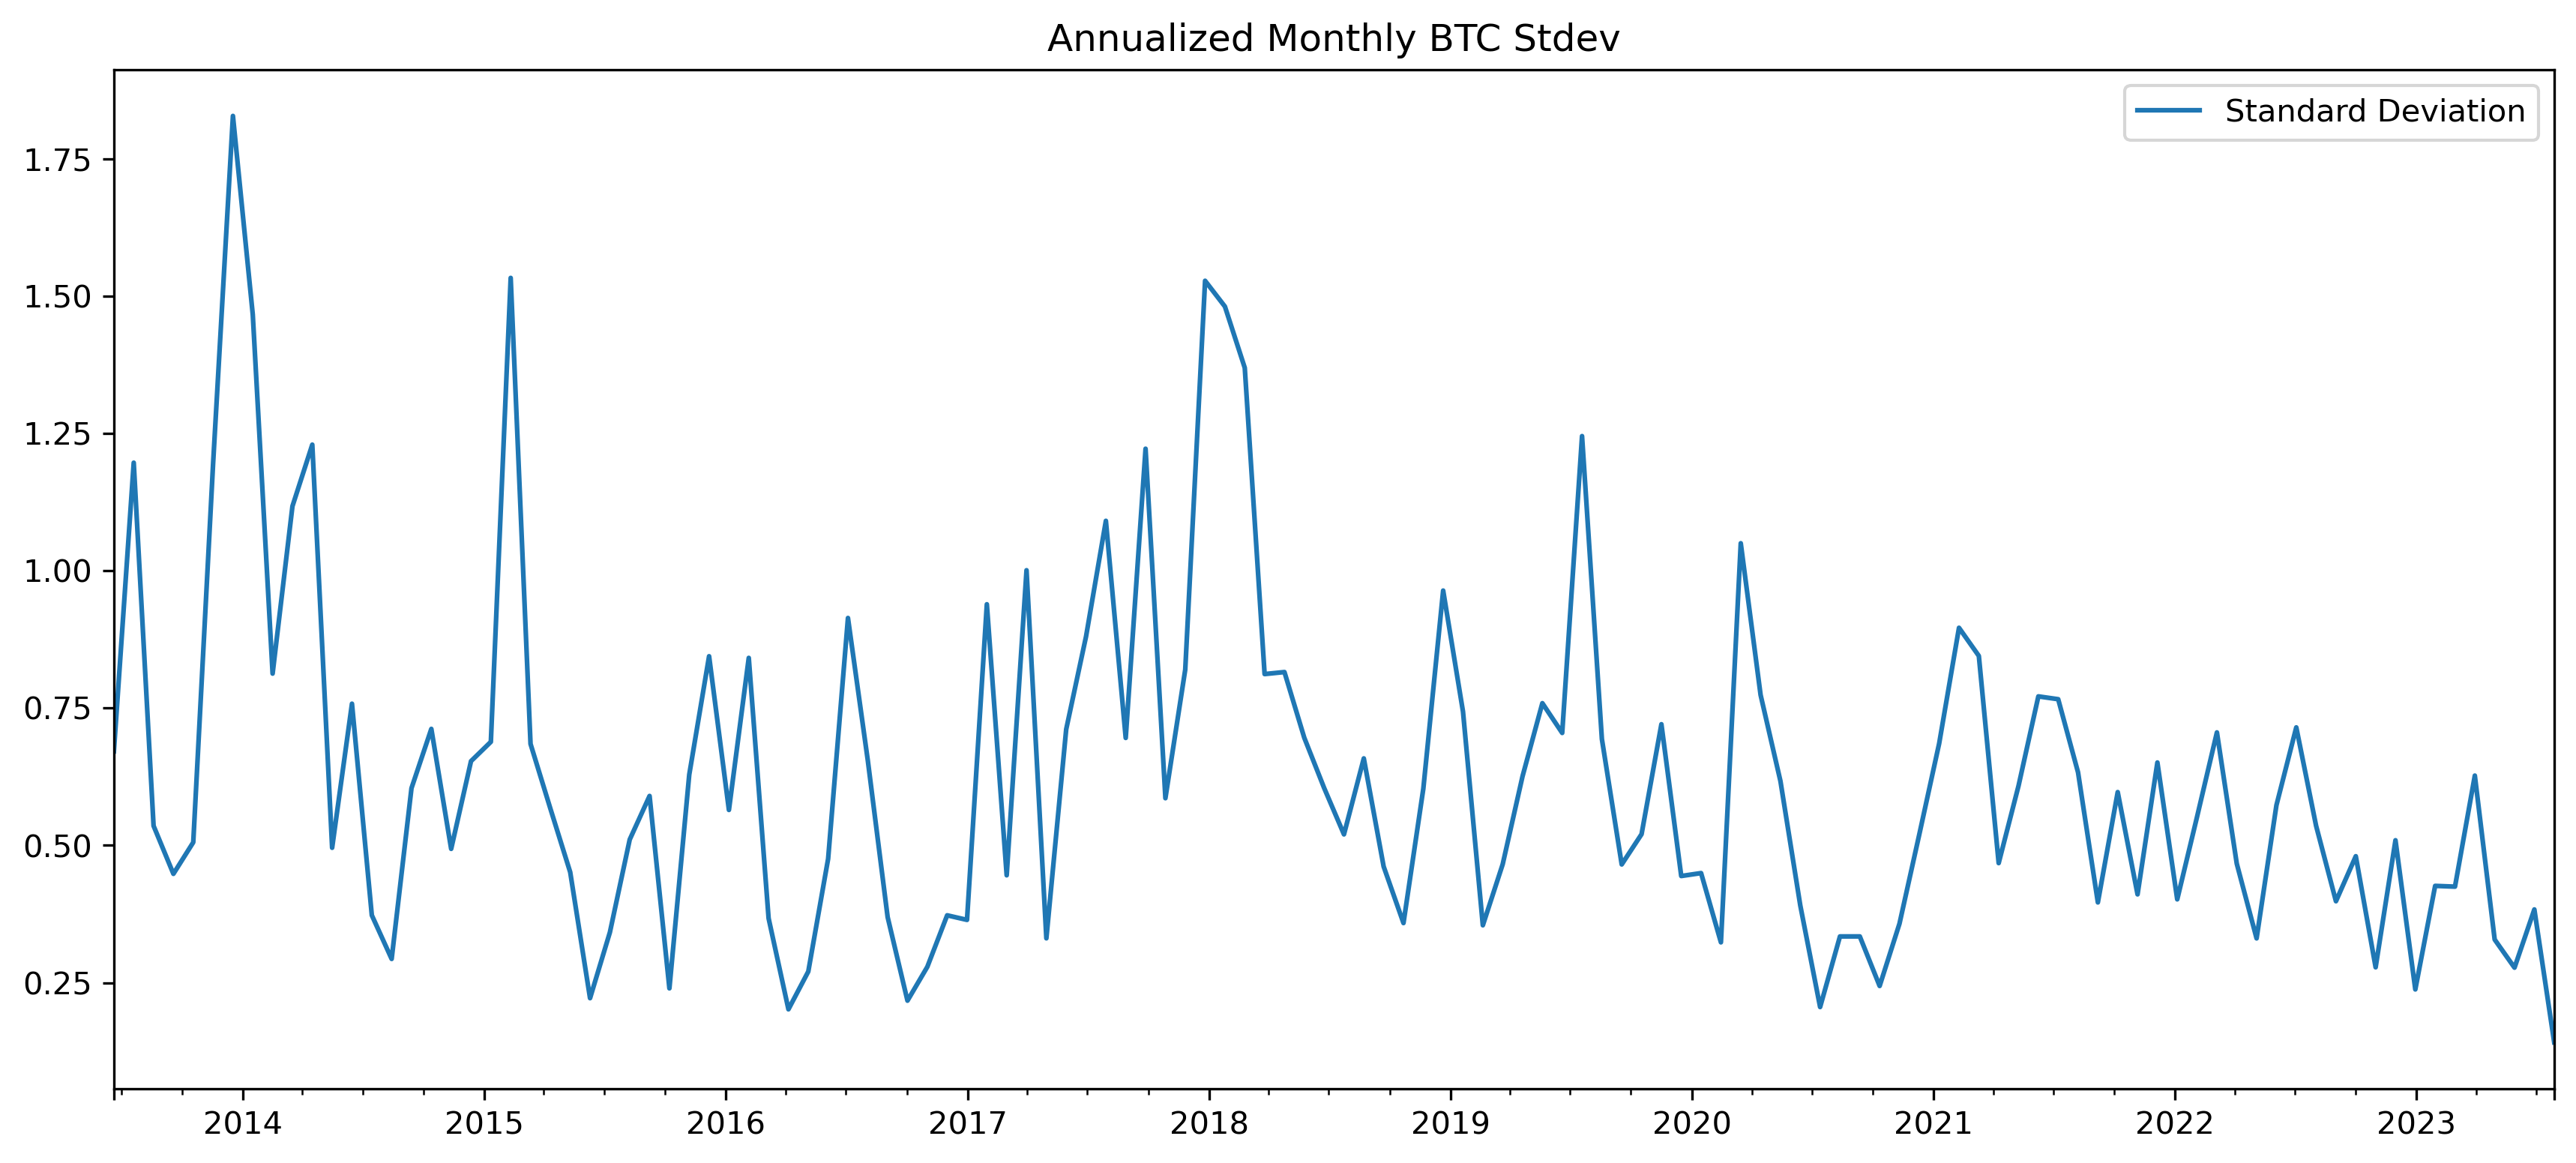

In [179]:
(std_TS(btc_CCR, dates)*np.sqrt(365)).plot(title = 'Annualized Monthly BTC Stdev')

In [180]:
dates = intervals(30, start = snp.index[1])

<AxesSubplot:title={'center':'Annualized Monthly SP500 Stdev'}>

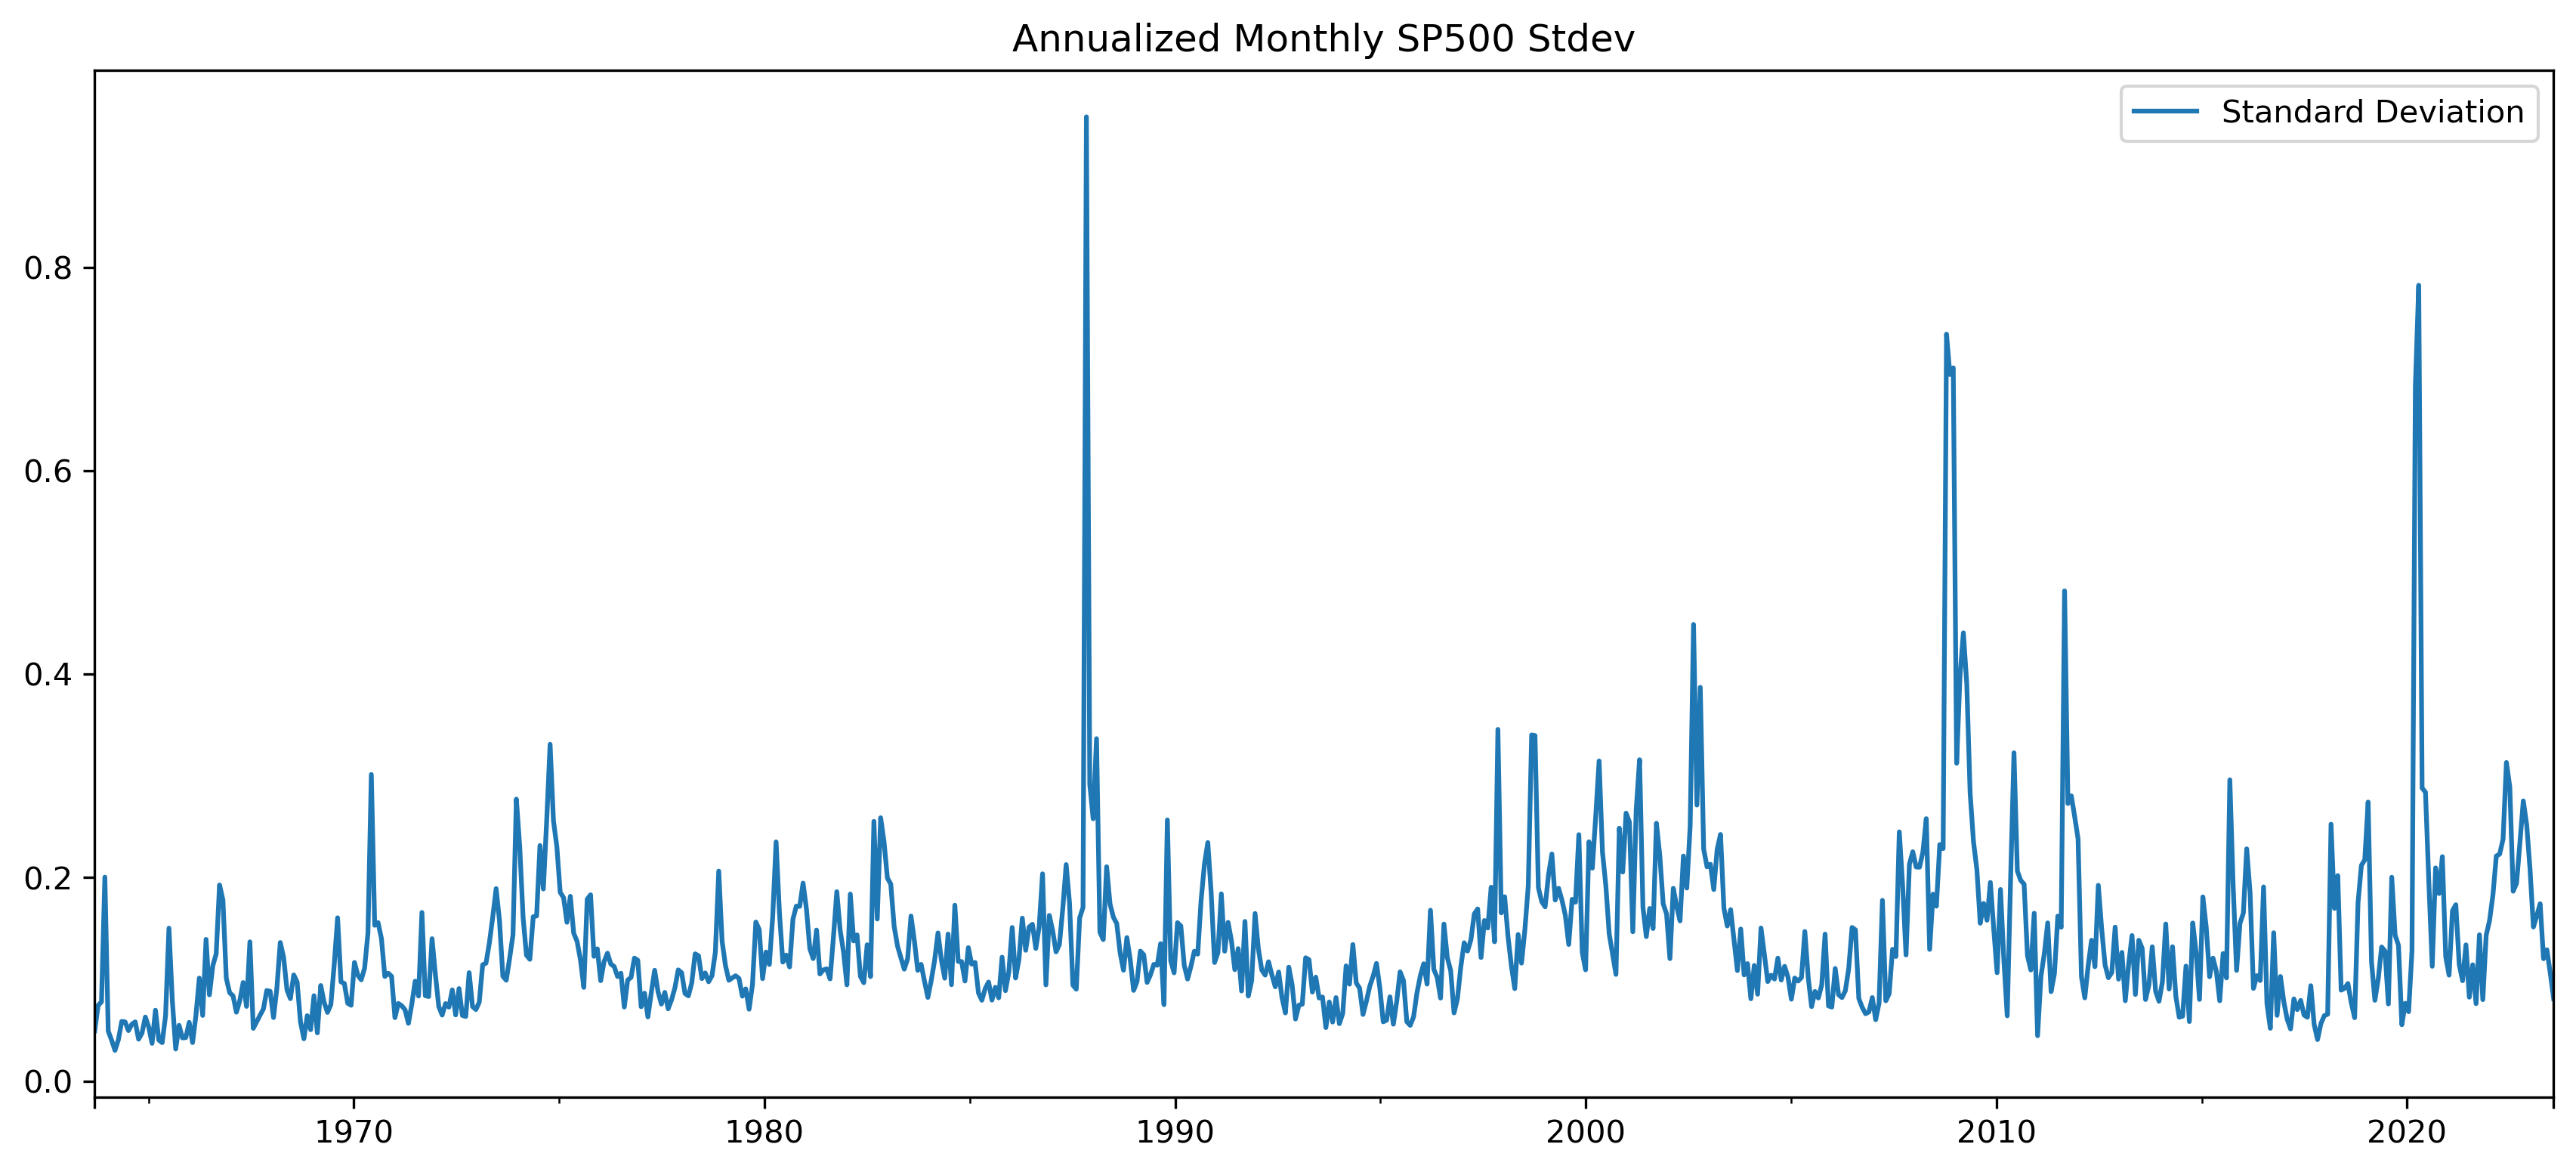

In [181]:
(std_TS(log_rates(snp), dates)*np.sqrt(252)).plot(title = 'Annualized Monthly SP500 Stdev')

# According to our methodology, crypto asset risk premiums should be:

In [182]:
prices = {}
returns = {}
stdev = []
risk_premium = []

In [208]:
rf = tnote[-1]/100
market_premium = 0.04
stdev_snp = np.std(log_rates(snp['Close'])) #daily

In [209]:
def calculate_discount_rate (token, rf=rf, market_premium=market_premium, stdev_snp=stdev_snp, start = dt.datetime(2013, 1, 1), end = dt.datetime.today()):

    price = get_price(token)
    returns = log_rates(price)
    stdev_x = np.std(returns)
    
    
    return float(rf + market_premium * stdev_x/stdev_snp)

In [211]:
coins = ['bitcoin', 'ethereum', 'binance-smart-chain', 'solana', 'polygon', 'polkadot', 'chainlink', 'uniswap', 'lido-finance', 'arbitrum', 'optimism', 'aave', 'dydx', 'makerdao', 'gmx']

In [212]:
discount_rates = []
for i in range(len(coins)): 
    discount_rates.append(float(calculate_discount_rate(coins[i])))
    
discount_rates = pd.DataFrame(discount_rates, coins, ['Decimal'])
discount_rates = discount_rates.sort_values(by=['Decimal'])

discount_rates

,Decimal
bitcoin,0.1853
arbitrum,0.1890
makerdao,0.2288
uniswap,0.2442
aave,0.2511
ethereum,0.2603
polkadot,0.2737
optimism,0.2782
chainlink,0.3018
dydx,0.3109
